# 18-13. 프로젝트: 뉴스기사 요약해보기

## 필요한 모듈 import

In [1]:
import urllib.request

import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 공개된 어텐션 함수 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

import requests
from summa.summarizer import summarize

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/aiffel0042/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 데이터 수집하기

In [2]:
# urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

data_summa = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1') # for testing summa

data.sample(10)

,headlines,text
40535,Moody's cuts India's GDP growth forecast to 7....,Global credit rating agency Moody's has cut In...
82408,Samsung to sell recycled Note 7 in South Korea...,South Korean smartphone maker Samsung on Sunda...
53700,Liverpool's Mohamed Salah named African Footba...,Liverpool's Egyptian forward Mohamed Salah was...
29455,We're not giving Rashid Khan to India: Afghan ...,Afghanistan President Ashraf Ghani tweeted to ...
55521,Cryptocurrency fuels irrational exuberance: Ba...,Bank of Korea Governor Lee Ju-yeol has said th...
13453,WhatsApp's Delete for Everyone feature gets re...,WhatsApp has updated its Delete for Everyone f...
41245,Why iPhone and iPad ads always display 9:41 AM...,The 9:41 AM time displayed on iPhone and iPad ...
16980,Facebook offers rewards for finding bugs in th...,Facebook is expanding its bug bounty program a...
9039,Loan waiver not a permanent solution: Venkaiah...,Vice-President Venkaiah Naidu on Thursday said...
66884,Sasikala granted 5-day parole to visit ailing ...,Sidelined AIADMK leader VK Sasikala was grante...


## 데이터 전처리하기 (추상적 요약)

In [3]:
# 중복 text 확인
print("중복 제거 전:", len(data['text']))
print("중복 제거 후:", data['text'].nunique(), '\n') # nunique(): number of unique elements https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.nunique.html

# 중복 제거
data.drop_duplicates(subset=['text'], inplace=True) # inplace: Whether to drop duplicates in place or to return a copy. https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html

print("drop_duplicates() 후:", len(data))

중복 제거 전: 98401
중복 제거 후: 98360 

drop_duplicates() 후: 98360


In [4]:
# NULL 데이터 확인
print(data.isnull().sum())

# NULL이 없으므로 아래 작업은 수행하지 않음
# data.dropna(axis=0, inplace=True)

headlines    0
text         0
dtype: int64


In [5]:
# 정규화 사전 만들기 https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
    "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
    "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
    "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
    "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
    "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
    "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
    "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
    "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
    "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
    "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
    "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
    "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
    "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
    "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
    "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
    "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
    "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
    "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [6]:
# 불용어 (텍스트에 자주 등장하지만 자연어 처리에 실질적으로 별 도움이 되지 않는 단어들) 제거
# stopwords: from nltk

print('불용어 개수:', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수: 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so

In [7]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

# 테스트
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [8]:
clean_text = []

# 전체 text 데이터에 대한 전처리
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [9]:
clean_headlines = []

# 전체 headlines 데이터에 대한 전처리
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

clean_headlines[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [10]:
# 정제 과정에서 빈 데이터 생겼는지 확인하고 NULL 값으로 대체
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [11]:
# NULL 데이터 확인
print(data.isnull().sum())

# NULL이 없으므로 아래 작업은 수행하지 않음
# data.dropna(axis=0, inplace=True)
# print('전체 샘플수 :',(len(data)))#데이터 전처리 함수

headlines    0
text         0
dtype: int64


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


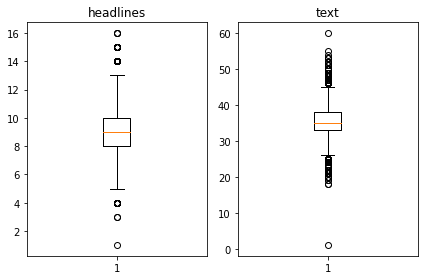

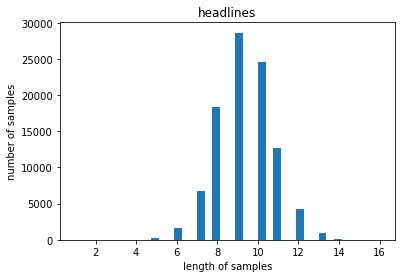

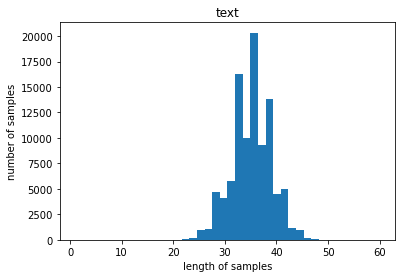

In [12]:
# 길이 분포 출력
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [13]:
# 위 그래프를 바탕으로 최대 길이 지정
text_max_len = 42
headlines_max_len = 11

In [14]:
# 시작 및 종료 토큰 추가
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [15]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [16]:
# 훈련 데이터와 테스트 데이터 분리

# 순서가 섞인 정수 시퀀스 (크기: encoder_input 과 같음)
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

# 만들어진 정수 시퀀스로 데이터의 샘플 순서를 재정의
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

# 8:2로 테스트 데이터 수 정의
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val, '\n')

# 정해진 테스트 데이터 수대로 데이터 분리
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

[73630 25049  6281 ... 36221 74522 86823]
테스트 데이터의 수 : 19672 

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


In [17]:
# 단어 집합 만들기
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69697
등장 빈도가 6번 이하인 희귀 단어의 수: 47505
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22192
단어 집합에서 희귀 단어의 비율: 68.15931819160078
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4901581594438627


In [18]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [19]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[952, 21, 55, 176, 66, 4508, 1168, 5, 403, 2198, 16, 125, 43, 2715, 7918, 304, 6325, 7918, 304, 1488, 7560, 873, 117, 1225, 403, 1, 66], [3566, 3031, 142, 341, 75, 256, 3139, 4438, 592, 4536, 2795, 174, 127, 3314, 2437, 2057, 81, 5295, 1183, 1077, 33, 675, 17, 6893, 2365, 6011, 3360, 3373, 406, 6726, 5847, 75, 17, 592, 1], [3, 13, 38, 265, 3721, 178, 82, 3819, 89, 53, 6470, 63, 7678, 7561, 26, 9, 7919, 608, 921, 1045, 6, 89, 63, 618, 4254, 3511, 2336, 570, 387]]


In [20]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [21]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30040
등장 빈도가 5번 이하인 희귀 단어의 수: 19606
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10434
단어 집합에서 희귀 단어의 비율: 65.26631158455393
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.618214295406828


In [22]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 389, 388, 77, 6, 13, 305, 712, 29], [1, 200, 1879, 707, 6, 332], [1, 12, 8, 1009, 3, 441, 128], [1, 131, 388, 44, 479, 4, 64, 12, 53], [1, 3, 623, 101, 602, 5, 1009]]
target
decoder  [[389, 388, 77, 6, 13, 305, 712, 29, 2], [200, 1879, 707, 6, 332, 2], [12, 8, 1009, 3, 441, 128, 2], [131, 388, 44, 479, 4, 64, 12, 53, 2], [3, 623, 101, 602, 5, 1009, 2]]


In [23]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 10
삭제할 테스트 데이터의 개수 : 4
훈련 데이터의 개수 : 78678
훈련 레이블의 개수 : 78678
테스트 데이터의 개수 : 19668
테스트 레이블의 개수 : 19668


In [24]:
# 패딩
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headlines_max_len, padding='post')

## 어텐션 매커니즘 사용하기 (추상적 요약)
* 모델 학습 후 그래프를 살펴보니 test 그래프 (주황색) 가 대략 10th epoch 이후 일정한 값으로 수렴하고 있다. 이에 따라 임의로 설정한 50 epochs가 다 돌지 않고 26th epoch에서 early stopped 됐다.

In [25]:
# 모델 설계하기

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.0) # 0.4 -> 0.0
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.0) # 0.4 -> 0.0
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.0) # 0.4 -> 0.0
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [26]:
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.0) # 0.2 -> 0.0
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

In [27]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 42, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 42, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_______________________________________________________________________________________

In [28]:
# 모델 훈련하기
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
308/308 [==============================] - 27s 88ms/step - loss: 4.2093 - val_loss: 3.8895
Epoch 2/50
308/308 [==============================] - 26s 85ms/step - loss: 3.7168 - val_loss: 3.5450
Epoch 3/50
308/308 [==============================] - 26s 85ms/step - loss: 3.4094 - val_loss: 3.3191
Epoch 4/50
308/308 [==============================] - 26s 86ms/step - loss: 3.1966 - val_loss: 3.1467
Epoch 5/50
308/308 [==============================] - 26s 86ms/step - loss: 3.0417 - val_loss: 3.0404
Epoch 6/50
308/308 [==============================] - 27s 88ms/step - loss: 2.9181 - val_loss: 2.9443
Epoch 7/50
308/308 [==============================] - 27s 86ms/step - loss: 2.8142 - val_loss: 2.8816
Epoch 8/50
308/308 [==============================] - 27s 87ms/step - loss: 2.7260 - val_loss: 2.8188
Epoch 9/50
308/308 [==============================] - 27s 87ms/step - loss: 2.6483 - val_loss: 2.7777
Epoch 10/50
308/308 [==============================] - 27s 87ms/step - loss: 2.579

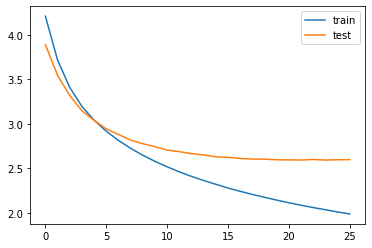

In [29]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [30]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [31]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 실제 결과와 요약문 비교하기 (추상적 요약)
* 50개의 샘플로 추상적 요약 결과를 실제 요약 (headline) 과 비교해본 결과 정확도가 떨어져 보였다. 원문의 주요한 단어들을 뽑아냈지만, 전반적으로 headline에 비해 원문의 내용을 한 눈에 이해하기는 어려운 요약 결과들이 대부분이었다.   
   
   
* 모델의 정확도가 떨어지는 것으로 추정된다. 예측 요약 결과를 지나치게 짧게 추출한 것도 요인이 아닐까 싶다.

In [32]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [33]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : chris starrer superhero film galaxy merit wrote hindustan times movie ability exist science fiction story strongest point said times india ndtv wrote film designed rated ndtv 
실제 요약 : of the on its own review 
예측 요약 :  chris hits the theatres


원문 : commerce giant amazon recalled lakh power banks us citing battery pose fire burn amazon received reports country including one report chemical burns due contact battery acid amazon also offering refund affected customers 
실제 요약 : amazon recalls lakh power banks in us over fire 
예측 요약 :  amazon to pay billion to


원문 : following demise former prime minister atal bihari vajpayee rajinikanth tweeted hear demise great shri vajpayee ji may soul rest peace titan departed wrote singer music director vishal hai mere ji ke ke tha wrote 
실제 요약 : by of great rajinikanth on vajpayee 
예측 요약 :  vajpayee was to late pm vajpayee


원문 : ram gopal varma offered reward lakh television employee named rohit able trace andhra pradesh chief minister chandrab

예측 요약 :  video of children in


원문 : batsman named man tournament recently concluded asia cup used sell puri living felt friend caught selling stop today added days always remember try stay keep working hard said 
실제 요약 : asia cup best player sold for living 
예측 요약 :  man who sold to sell for asia cup


원문 : responding opposition remarks government prepare deal pakistan external affairs minister sushma swaraj said day stop terror talks start added government prepared peace friendship things pakistan pm nawaz sharif declared hizbul terrorist wani 
실제 요약 : with pak will start the day it stops terror swaraj 
예측 요약 :  pak govt talks cannot stop terrorism pak


원문 : pay merchant discount rate banks debit cards upi aadhaar based transactions january rate charged merchant bank providing debit credit card services charges government banks next two years 
실제 요약 : no charges on card payments of up to from now 
예측 요약 :  banks to pay credit card for not


원문 : bjp leader monday filed plea supreme 

## Summa를 이용해 추출적 요약 해보기
* 정제된 text를 재료로 시도하니 추출적 요약이 되지 않았다. 입력 문장의 길이가 일정 수준 이상 확보되어야 하는 것으로 보인다. 부득이하게 정제하지 않은 원본 데이터로 추출적 요약을 시도해봤다.   
   
   
* 실제 요약 (데이터 내 headline) 과 summa를 이용한 추출적 요약의 내용은 전반적으로 크게 다르지 않았다. 다만 ratio를 실제 요약 (headline) 수준으로 낮추면 결과가 나오지 않아 길게 설정했더니, 전반적으로 좀 더 장황한 문장이 나왔다. 실제 요약에는 'Bosch' 로만 표기된 것이 추출적 요약에서는 'German multinational engineering and electronics firm Bosch' 로 수식어가 붙어 있는 식이다.   
   
   
* 추출적 요약은 길이가 충분히 긴 입력 문장을 대상으로 사용해야 할 것 같다.

In [38]:
for i in range(100, 120):
    print("원문 :", data_summa['text'][i])
    print("실제 요약 :", data_summa['headlines'][i])
    print("추출적 요약 :", summarize(data_summa['text'][i], ratio=0.5), '\n')

원문 : German multinational engineering and electronics firm Bosch has made its first investment in India in Bengaluru-based deep-tech startup SimYog. SimYog has raised about Ã¢ÂÂ¹6.3 crore in the funding round, with participation from early-stage venture capital firm Ideaspring Capital. Incubated at the Indian Institute of Science (IISc), it provides design and sign-off tools for automotive electronics.
실제 요약 : Bosch makes its 1st India investment in IISc spinoff SimYog
추출적 요약 : German multinational engineering and electronics firm Bosch has made its first investment in India in Bengaluru-based deep-tech startup SimYog. SimYog has raised about Ã¢ÂÂ¹6.3 crore in the funding round, with participation from early-stage venture capital firm Ideaspring Capital. 

원문 : Mumbai-headquartered talent technology startup Shortlist has raised $2 million in a Series A round of funding. The round was led by Blue Haven Initiative, with participation from Compass Venture Capital, Zephyr Acorn among oth